In [ ]:
# Download CORnet-S model
!pip uninstall -y cornet
!pip install git+https://github.com/dicarlolab/CORnet

from google.colab import drive
drive.mount('/content/drive')

  Cloning https://github.com/dicarlolab/CORnet to /tmp/pip-req-build-jcv7b6y7
  Running command git clone --filter=blob:none --quiet https://github.com/dicarlolab/CORnet /tmp/pip-req-build-jcv7b6y7
  Resolved https://github.com/dicarlolab/CORnet to commit d0cc17d4b34ad44dedb01683b70eafd15515adad
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from cornet.cornet_s import CORblock_S
import json
from datetime import datetime

BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Fifth Experiment"
DATA_ROOT = "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/LFWCrop_dataset_pytorch"
PREVIOUS_MODELS_PATH = "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Forth Experiment/models/pretrained/full_finetune"

MODEL_DIR = os.path.join(BASE_PATH, "models")
OUTPUT_DIR = os.path.join(BASE_PATH, "output")

def ensure_directories():
    dirs = [
        MODEL_DIR,
        OUTPUT_DIR,
        os.path.join(OUTPUT_DIR, "training_curves"),
        os.path.join(OUTPUT_DIR, "predictions"),
        os.path.join(OUTPUT_DIR, "saliency"),
        os.path.join(OUTPUT_DIR, "comparisons"),
        os.path.join(MODEL_DIR, "hybrid")
    ]
    for directory in dirs:
        os.makedirs(directory, exist_ok=True)

    print("所有必要的目录已创建")

ensure_directories()

# Preopare to read the image pair
def read_pairs(file_path, label):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return [(line.strip().split()[0], line.strip().split()[1], label) for line in lines]

def load_all_pairs(list_dir):
    all_pairs = []
    for i in range(1, 11):
        prefix = f"{i:02d}"
        for split in ["train", "test"]:
            same_file = os.path.join(list_dir, f"{prefix}_{split}_same.txt")
            diff_file = os.path.join(list_dir, f"{prefix}_{split}_diff.txt")
            all_pairs += read_pairs(same_file, 1)
            all_pairs += read_pairs(diff_file, 0)
    return all_pairs

class FacePairsDataset(Dataset):
    def __init__(self, pairs, image_dir, transform=None):
        self.pairs = pairs
        self.image_dir = image_dir
        self.transform = transform or transforms.ToTensor()

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        name1, name2, label = self.pairs[idx]
        name1 += ".ppm"
        name2 += ".ppm"
        img1 = Image.open(os.path.join(self.image_dir, name1)).convert("RGB")
        img2 = Image.open(os.path.join(self.image_dir, name2)).convert("RGB")
        return self.transform(img1), self.transform(img2), torch.tensor(label, dtype=torch.float32)

def get_data_loaders():
    face_dir = os.path.join(DATA_ROOT, "faces")
    list_dir = os.path.join(DATA_ROOT, "lists")

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    pairs = load_all_pairs(list_dir)
    split_idx = int(0.9 * len(pairs))
    train_pairs = pairs[:split_idx]
    val_pairs = pairs[split_idx:]

    train_dataset = FacePairsDataset(train_pairs, face_dir, transform=transform)
    val_dataset = FacePairsDataset(val_pairs, face_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=8, pin_memory=True)

    return train_loader, val_loader, train_dataset, val_dataset

# Hybrid CORnet Model Design
class HybridCORnetEmbedding(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        # Use Resnet18 as the backbone
        self.resnet = models.resnet18(pretrained=pretrained)

        # Use the 002 model (1 V1, 1 V2, 1 V4, 2 IT)
        self.v2_time = 0
        self.v4_time = 0
        self.it_time = 2

        # IT block
        if self.it_time > 1:
            self.IT_recurrent = CORblock_S(512, 512, times=self.it_time-1)

        # HED structure (side conv)
        self.side1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1),  # post V1 feature
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.side2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1),  # post V2 feature
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        self.side3 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=1),  # post V4 feature
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )

        # Feature Fusion
        self.fusion = nn.Sequential(
            nn.Conv2d(384, 512, kernel_size=1),  # 128x3 combined three features
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # Attention Weights
        self.attention = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=1),  # 512 backone + 512 fusion
            nn.BatchNorm2d(512),
            nn.Sigmoid()  # Generate weight attention between 0 - 1
        )

        # Pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

    def forward(self, x):
        # V1: conv1 + bn1 + relu + maxpool
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x1 = self.resnet.maxpool(x)

        # V2: layer1
        x2 = self.resnet.layer1(x1)

        # V4: layer2
        x3 = self.resnet.layer2(x2)

        # IT: layer3 + layer4
        x = self.resnet.layer3(x3)
        x = self.resnet.layer4(x)
        if self.it_time > 1:
            x = self.IT_recurrent(x)

        side1_feat = self.side1(x1)
        side2_feat = self.side2(x2)
        side3_feat = self.side3(x3)

        side1_feat = F.adaptive_avg_pool2d(side1_feat, x.size()[2:])
        side2_feat = F.adaptive_avg_pool2d(side2_feat, x.size()[2:])
        side3_feat = F.adaptive_avg_pool2d(side3_feat, x.size()[2:])

        fusion_feat = torch.cat([side1_feat, side2_feat, side3_feat], dim=1)
        fusion_feat = self.fusion(fusion_feat)

        combined = torch.cat([x, fusion_feat], dim=1)
        attention_weights = self.attention(combined)

        output = x * attention_weights + fusion_feat * (1 - attention_weights)

        output = self.pool(output)
        output = self.flatten(output)

        return output

# Siamese
class SiameseHybridCORnet(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.embedding_net = HybridCORnetEmbedding(pretrained=pretrained)

    def forward(self, x1, x2):
        f1 = self.embedding_net(x1)
        f2 = self.embedding_net(x2)
        return f1, f2

class PretrainedCORnetEmbedding(nn.Module):
    def __init__(self, times_dict, pretrained=True):
        super().__init__()
        self.resnet = models.resnet18(pretrained=pretrained)

        def get_times(region): return times_dict.get(region, 2)
        self.v2_time = get_times('V2')
        self.v4_time = get_times('V4')
        self.it_time = get_times('IT')

        # V2: layer1输出 64
        if self.v2_time > 1:
            self.V2_recurrent = CORblock_S(64, 64, times=self.v2_time-1)

        # V4: layer2 128
        if self.v4_time > 1:
            self.V4_recurrent = CORblock_S(128, 128, times=self.v4_time-1)

        # IT: layer4 512
        if self.it_time > 1:
            self.IT_recurrent = CORblock_S(512, 512, times=self.it_time-1)

        # Resnet Pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

    def forward(self, x):
        # V1: conv1 + bn1 + relu + maxpool
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        # V2: layer1 (BasicBlock x2)
        x = self.resnet.layer1(x)
        if self.v2_time > 1:
            x = self.V2_recurrent(x)

        # V4: layer2 (BasicBlock x2)
        x = self.resnet.layer2(x)
        if self.v4_time > 1:
            x = self.V4_recurrent(x)

        # IT: layer3 (BasicBlock x2) + layer4 (BasicBlock x2)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        if self.it_time > 1:
            x = self.IT_recurrent(x)

        x = self.pool(x)
        x = self.flatten(x)

        return x

class SiamesePretrainedCORnet(nn.Module):
    def __init__(self, times_dict, pretrained=True, freeze_backbone=False):
        super().__init__()
        self.embedding_net = PretrainedCORnetEmbedding(times_dict, pretrained=pretrained)

        if freeze_backbone:
            for param in self.embedding_net.resnet.parameters():
                param.requires_grad = False

            if hasattr(self.embedding_net, 'V2_recurrent'):
                for param in self.embedding_net.V2_recurrent.parameters():
                    param.requires_grad = True

            if hasattr(self.embedding_net, 'V4_recurrent'):
                for param in self.embedding_net.V4_recurrent.parameters():
                    param.requires_grad = True

            if hasattr(self.embedding_net, 'IT_recurrent'):
                for param in self.embedding_net.IT_recurrent.parameters():
                    param.requires_grad = True

    def forward(self, x1, x2):
        f1 = self.embedding_net(x1)
        f2 = self.embedding_net(x2)
        return f1, f2

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss = (label) * torch.pow(euclidean_distance, 2) + \
               (1 - label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        return loss.mean()

def compute_accuracy(out1, out2, labels, threshold=0.5):
    distances = F.pairwise_distance(out1, out2)
    preds = (distances < threshold).float()
    correct = (preds == labels).float().sum()
    accuracy = correct / labels.size(0)
    return accuracy.item()

def train_hybrid_model(num_epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")

    train_loader, val_loader, _, _ = get_data_loaders()

    model = SiameseHybridCORnet(pretrained=True).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"混合模型总参数数量: {total_params:,}")
    print(f"可训练参数数量: {trainable_params:,}")
    print(f"冻结参数比例: {100 * (total_params - trainable_params) / total_params:.2f}%")

    save_model_parameters_stats(model, "hybrid")

    criterion = ContrastiveLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

    scaler = torch.cuda.amp.GradScaler()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    hybrid_model_dir = os.path.join(MODEL_DIR, "hybrid")
    epoch_data_dir = os.path.join(hybrid_model_dir, "epoch_data")
    os.makedirs(hybrid_model_dir, exist_ok=True)
    os.makedirs(epoch_data_dir, exist_ok=True)

    best_val_acc = 0.0
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                out1, out2 = model(img1, img2)
                loss = criterion(out1, out2, label)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            acc = compute_accuracy(out1, out2, label)
            running_loss += loss.item()
            running_acc += acc

        train_loss = running_loss / len(train_loader)
        train_acc = running_acc / len(train_loader)

        model.eval()
        running_loss = 0.0
        running_acc = 0.0
        with torch.no_grad():
            for img1, img2, label in val_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)

                with torch.cuda.amp.autocast():
                    out1, out2 = model(img1, img2)
                    loss = criterion(out1, out2, label)

                acc = compute_accuracy(out1, out2, label)
                running_loss += loss.item()
                running_acc += acc

        val_loss = running_loss / len(val_loader)
        val_acc = running_acc / len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | 训练损失: {train_loss:.5f}, 训练准确率: {train_acc:.5f} | 验证损失: {val_loss:.5f}, 验证准确率: {val_acc:.5f}")

        epoch_results = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accs': train_accuracies,
            'val_accs': val_accuracies,
            'current_epoch': epoch + 1
        }

        with open(os.path.join(epoch_data_dir, f"epoch_{epoch+1}_data.json"), 'w') as f:
            json.dump(epoch_results, f, indent=2)

        if (epoch + 1) % 3 == 0 or epoch == num_epochs - 1 or val_acc > best_val_acc:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_acc': train_acc,
                'val_acc': val_acc
            }

            checkpoint_path = os.path.join(hybrid_model_dir, f"checkpoint_epoch{epoch+1}.pt")
            torch.save(checkpoint, checkpoint_path)
            print(f"检查点已保存: {checkpoint_path}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_epoch = epoch + 1
                best_model_path = os.path.join(hybrid_model_dir, "best_model.pt")
                torch.save(model.state_dict(), best_model_path)
                print(f"发现新的最佳模型 (验证准确率: {val_acc:.5f})，已保存到: {best_model_path}")

    plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies, "hybrid")

    final_model_path = os.path.join(hybrid_model_dir, "hybrid_model.pt")
    torch.save(model.state_dict(), final_model_path)
    print(f"最终模型已保存到: {final_model_path}")

    report = {
        "num_epochs": num_epochs,
        "final_train_loss": train_losses[-1],
        "final_val_loss": val_losses[-1],
        "final_train_acc": train_accuracies[-1],
        "final_val_acc": val_accuracies[-1],
        "best_val_acc": best_val_acc,
        "best_epoch": best_epoch,
        "total_params": total_params,
        "trainable_params": trainable_params
    }

    with open(os.path.join(hybrid_model_dir, "training_report.json"), 'w') as f:
        json.dump(report, f, indent=2)

    return model

def save_model_parameters_stats(model, model_name="hybrid"):

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params

    region_params = {}

    if model_name == "hybrid":
        resnet_params = sum(p.numel() for name, p in model.named_parameters()
                         if 'embedding_net.resnet' in name and 'side' not in name
                         and 'fusion' not in name and 'attention' not in name)
        side_params = sum(p.numel() for name, p in model.named_parameters()
                       if 'side' in name)
        fusion_params = sum(p.numel() for name, p in model.named_parameters()
                         if 'fusion' in name)
        attention_params = sum(p.numel() for name, p in model.named_parameters()
                           if 'attention' in name)
        it_params = sum(p.numel() for name, p in model.named_parameters()
                     if 'IT_recurrent' in name)

        region_params = {
            'ResNet骨干网络': resnet_params,
            '侧边连接模块': side_params,
            '特征融合模块': fusion_params,
            '注意力机制': attention_params,
            'IT递归层': it_params
        }
    else:
        resnet_params = sum(p.numel() for name, p in model.named_parameters()
                         if 'embedding_net.resnet' in name)
        v2_params = sum(p.numel() for name, p in model.named_parameters()
                     if 'V2_recurrent' in name)
        v4_params = sum(p.numel() for name, p in model.named_parameters()
                     if 'V4_recurrent' in name)
        it_params = sum(p.numel() for name, p in model.named_parameters()
                     if 'IT_recurrent' in name)

        region_params = {
            'ResNet骨干网络': resnet_params,
            'V2递归层': v2_params,
            'V4递归层': v4_params,
            'IT递归层': it_params
        }

    stats_dir = os.path.join(MODEL_DIR, model_name)
    os.makedirs(stats_dir, exist_ok=True)

    stats = {
        'model_name': model_name,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'frozen_params': frozen_params,
        'frozen_ratio': frozen_params / total_params if total_params > 0 else 0,
        'region_params': region_params
    }

    with open(os.path.join(stats_dir, "model_parameters_stats.json"), 'w', encoding='utf-8') as f:
        json.dump(stats, f, indent=2, ensure_ascii=False)

    with open(os.path.join(stats_dir, "model_parameters_stats.txt"), 'w', encoding='utf-8') as f:
        f.write(f"# {model_name} 模型参数统计\n\n")
        f.write(f"总参数数量: {total_params:,}\n")
        f.write(f"可训练参数数量: {trainable_params:,}\n")
        f.write(f"冻结参数数量: {frozen_params:,}\n")
        f.write(f"冻结参数比例: {100 * frozen_params / total_params:.2f}%\n\n")

        f.write("## 各区域参数分布\n\n")
        for region, count in region_params.items():
            if count > 0:
                f.write(f"- {region}: {count:,} ({count/total_params*100:.2f}%)\n")

    return stats

def plot_training_curves(train_losses, val_losses, train_accs, val_accs, model_name="hybrid"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses) + 1)
    plt.plot(epochs, train_losses, 'b-', label='训练损失')
    plt.plot(epochs, val_losses, 'r-', label='验证损失')
    plt.title(f"{model_name} 模型训练损失曲线")
    plt.xlabel("Epoch")
    plt.ylabel("损失")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, [acc * 100 for acc in train_accs], 'b-', label='训练准确率')
    plt.plot(epochs, [acc * 100 for acc in val_accs], 'r-', label='验证准确率')
    plt.title(f"{model_name} 模型训练准确率曲线")
    plt.xlabel("Epoch")
    plt.ylabel("准确率 (%)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()

    curves_dir = os.path.join(OUTPUT_DIR, "training_curves")
    os.makedirs(curves_dir, exist_ok=True)
    save_path = os.path.join(curves_dir, f"{model_name}_training_curves.png")
    plt.savefig(save_path, dpi=300)
    print(f"训练曲线已保存到: {save_path}")
    plt.close()

def predict_models_comparison(hybrid_model_path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    image_pairs = [
        ("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion.jpg",
         "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion_n.jpg",
         "Part_Whole_Illusion"),

        ("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion2.jpg",
         "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Part_Whole_Illusion_n2.jpg",
         "Part_Whole_Illusion2"),

        ("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test2.jpg",
         "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test_n2.jpg",
         "Margaret_Thatcher2"),

        ("/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test.jpg",
         "/content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /First Experiment/Margaret Thatcher_test_n.jpg",
         "Margaret_Thatcher")
    ]

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])

    # Time Settings (Claim: This is different from the final number of blocks)
    time_settings = {
        "0_0_1": {"V2": 0, "V4": 0, "IT": 1},
        "0_0_2": {"V2": 0, "V4": 0, "IT": 2},
        "0_0_4": {"V2": 0, "V4": 0, "IT": 4},
        "0_2_1": {"V2": 0, "V4": 2, "IT": 1},
        "0_2_2": {"V2": 0, "V4": 2, "IT": 2},
        "0_2_4": {"V2": 0, "V4": 2, "IT": 4},
        "2_4_1": {"V2": 2, "V4": 4, "IT": 1},
        "2_4_2": {"V2": 2, "V4": 4, "IT": 2},
        "2_4_4": {"V2": 2, "V4": 4, "IT": 4},
        "5_10_5": {"V2": 5, "V4": 10, "IT": 5}
    }

    early_models = ["0_0_1", "0_0_2", "0_0_4", "0_2_1", "0_2_2", "0_2_4"]

    def sort_key(name):
        return list(map(int, name.split("_")))

    hybrid_model = SiameseHybridCORnet(pretrained=False).to(device)
    try:
        hybrid_model.load_state_dict(torch.load(hybrid_model_path, map_location=device))
        print(f"加载混合模型成功: {hybrid_model_path}")
    except Exception as e:
        print(f"加载混合模型失败: {e}")
        return

    pred_dir = os.path.join(OUTPUT_DIR, "predictions")
    os.makedirs(pred_dir, exist_ok=True)

    for img1_path, img2_path, name in image_pairs:
        print(f"\n预测图片对: {name}")

        try:
            img1 = transform(Image.open(img1_path).convert("RGB")).unsqueeze(0).to(device)
            img2 = transform(Image.open(img2_path).convert("RGB")).unsqueeze(0).to(device)

            results = {
                'standard': {"distances": [], "probs": []},
                'hybrid': {"distances": [], "probs": []}
            }

            hybrid_model.eval()
            with torch.no_grad():
                out1, out2 = hybrid_model(img1, img2)
                dist = F.pairwise_distance(out1, out2).item()
                prob = torch.sigmoid(torch.tensor(-10 * dist + 5)).item()

            print(f"混合模型 → 距离={dist:.4f}, 相同概率={prob:.4f}")
            results['hybrid']['distances'].append(dist)
            results['hybrid']['probs'].append(prob)

            sorted_keys = sorted(time_settings.keys(), key=sort_key)
            for structure_name in sorted_keys:
                times_dict = time_settings[structure_name]

                model = SiamesePretrainedCORnet(times_dict, pretrained=False, freeze_backbone=False).to(device)

                model_path = os.path.join(PREVIOUS_MODELS_PATH, f"pretrained_model_T{structure_name}.pt")

                if os.path.exists(model_path):
                    try:
                        model.load_state_dict(torch.load(model_path, map_location=device))
                    except Exception as e:
                        print(f"无法加载权重 {structure_name}: {e}")
                        continue
                else:
                    print(f"未找到模型 {structure_name}, 跳过")
                    continue

                model.eval()
                with torch.no_grad():
                    out1, out2 = model(img1, img2)
                    dist = F.pairwise_distance(out1, out2).item()
                    prob = torch.sigmoid(torch.tensor(-10 * dist + 5)).item()

                print(f"{structure_name} → 距离={dist:.4f}, 相同概率={prob:.4f}")
                results['standard']['distances'].append(dist)
                results['standard']['probs'].append(prob)

            std_probs = results['standard']['probs']
            overall_max_idx = np.argmax(std_probs)

            early_indices = [i for i, key in enumerate(sorted_keys) if key in early_models]
            early_max_idx = early_indices[np.argmax([std_probs[i] for i in early_indices])]

            plt.figure(figsize=(16, 6))

            plt.subplot(1, 2, 1)
            plt.plot(sorted_keys, std_probs*100, 'b-o', label="Standard Models", linewidth=1.5, alpha=0.7)

            if overall_max_idx == early_max_idx:
                plt.plot(sorted_keys[early_max_idx], std_probs[early_max_idx], 'ro', markersize=8,
                         label=f'Highest ({sorted_keys[early_max_idx]})', zorder=10)
            else:
                plt.plot(sorted_keys[overall_max_idx], std_probs[overall_max_idx], 'mo', markersize=8,
                         label=f'Overall Highest ({sorted_keys[overall_max_idx]})', zorder=11)
                plt.plot(sorted_keys[early_max_idx], std_probs[early_max_idx], 'ro', markersize=8,
                         label=f'Early Models Highest ({sorted_keys[early_max_idx]})', zorder=10)

            plt.axhline(y=results['hybrid']['probs'][0] * 100, color='g', linestyle='--',
                       label=f'Hybrid Model ({results["hybrid"]["probs"][0]*100:.1f}%)')

            plt.title(f"Model Comparison - {name}")
            plt.xlabel("Time Settings")
            plt.ylabel("Probability (%)")
            plt.xticks(rotation=45)
            plt.grid(True, alpha=0.3)
            plt.legend()

            plt.subplot(1, 2, 2)

            compare_models = ['0_0_2', '0_0_4', 'Hybrid']

            idx_002 = sorted_keys.index('0_0_2')
            idx_004 = sorted_keys.index('0_0_4')

            compare_probs = [
                std_probs[idx_002] * 100,
                std_probs[idx_004] * 100,
                results['hybrid']['probs'][0] * 100
            ]

            compare_distances = [
                results['standard']['distances'][idx_002],
                results['standard']['distances'][idx_004],
                results['hybrid']['distances'][0]
            ]

            x = np.arange(len(compare_models))
            width = 0.35

            ax1 = plt.gca()
            ax2 = ax1.twinx()

            bars1 = ax1.bar(x - width/2, compare_distances, width, color='blue', alpha=0.7, label='Distance')
            ax1.set_ylabel('Distance', color='blue')
            ax1.tick_params(axis='y', labelcolor='blue')

            bars2 = ax2.bar(x + width/2, compare_probs, width, color='orange', alpha=0.7, label='Probability')
            ax2.set_ylabel('Probability (%)', color='orange')
            ax2.tick_params(axis='y', labelcolor='orange')

            for i, d in enumerate(compare_distances):
                ax1.text(x[i] - width/2, d + 0.02, f"{d:.4f}", ha='center')

            for i, p in enumerate(compare_probs):
                ax2.text(x[i] + width/2, p + 1, f"{p:.1f}%", ha='center')

            plt.title(f"Detailed Comparison - {name}")
            plt.xticks(x, compare_models)
            plt.grid(axis='y', alpha=0.3)

            save_path = os.path.join(pred_dir, f"{name}_models_comparison.png")
            plt.tight_layout()
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"保存比较图 → {save_path}")
            plt.close()

        except Exception as e:
            print(f"处理图片对 {name} 时出错: {e}")

def generate_hybrid_saliency_maps(dataset, hybrid_model_path, top_percent=0.1, intensity=0.9, num_images=10):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    save_dir = os.path.join(OUTPUT_DIR, "saliency/hybrid_model")
    os.makedirs(save_dir, exist_ok=True)

    hybrid_model = SiameseHybridCORnet(pretrained=False).to(device)
    if os.path.exists(hybrid_model_path):
        try:
            hybrid_model.load_state_dict(torch.load(hybrid_model_path, map_location=device))
            print(f"加载混合模型成功: {hybrid_model_path}")
        except Exception as e:
            print(f"加载混合模型失败: {e}")
            print("使用初始化权重")
    else:
        print(f"未找到模型文件: {hybrid_model_path}")
        print("使用初始化权重")

    hybrid_model.eval()

    for i in range(num_images):
        img_tensor, _, _ = dataset[i]
        img_tensor = img_tensor.unsqueeze(0).to(device).requires_grad_()

        hybrid_model.zero_grad()
        out1, _ = hybrid_model(img_tensor, img_tensor)
        score = out1.norm()
        score.backward()

        saliency, _ = torch.max(img_tensor.grad.data.abs(), dim=1)
        saliency = saliency[0].detach().cpu().numpy()

        flat_saliency = saliency.flatten()
        num_top_pixels = int(len(flat_saliency) * top_percent)
        threshold = np.partition(flat_saliency, -num_top_pixels)[-num_top_pixels]

        img_np = img_tensor[0].detach().cpu().permute(1, 2, 0).numpy()
        img_np = np.clip(img_np, 0, 1)
        saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-5)
        alpha = saliency_norm * intensity

        modified_img = img_np.copy()
        modified_img[..., 0] += alpha * (1 - modified_img[..., 0])
        modified_img[..., 1] *= (1 - alpha)
        modified_img[..., 2] *= (1 - alpha)

        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(img_np)
        axes[0].set_title(f"Original image (Hybrid)")
        axes[0].axis("off")

        axes[1].imshow(modified_img)
        axes[1].set_title(f"Saliency map (Hybrid)")
        axes[1].axis("off")

        plt.tight_layout()
        save_path = os.path.join(save_dir, f"saliency_{i}.png")
        plt.savefig(save_path)
        print(f"Saved saliency map Hybrid sample {i} → {save_path}")
        plt.close()

所有必要的目录已创建


开始执行混合HED-CORnet模型实验
实验开始时间: 2025-05-05 13:49:49.163588
所有必要的目录已创建

[1/3] 开始训练混合模型...
使用设备: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


混合模型总参数数量: 52,827,816
可训练参数数量: 52,827,816
冻结参数比例: 0.00%


<ipython-input-3-8db61b7d93bd>:347: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-3-8db61b7d93bd>:371: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
<ipython-input-3-8db61b7d93bd>:395: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10 | 训练损失: 4.75998, 训练准确率: 0.50001 | 验证损失: 0.96634, 验证准确率: 0.50133
检查点已保存: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Fifth Experiment/models/hybrid/checkpoint_epoch1.pt
发现新的最佳模型 (验证准确率: 0.50133)，已保存到: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Fifth Experiment/models/hybrid/best_model.pt
Epoch 2/10 | 训练损失: 0.58411, 训练准确率: 0.50002 | 验证损失: 0.35475, 验证准确率: 0.50150
检查点已保存: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Fifth Experiment/models/hybrid/checkpoint_epoch2.pt
发现新的最佳模型 (验证准确率: 0.50150)，已保存到: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Fifth Experiment/models/hybrid/best_model.pt
Epoch 3/10 | 训练损失: 0.28340, 训练准确率: 0.50253 | 验证损失: 0.22561, 验证准确率: 0.51479
检查点已保存: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Fifth Experiment/models/hybrid/checkpoint_epoch3.pt
发现新的最佳模型 (验证准确率: 0.51479)，已保存到: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Fifth Experim

<ipython-input-3-8db61b7d93bd>:583: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-8db61b7d93bd>:583: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-8db61b7d93bd>:583: UserWarning: Glyph 27169 (\N{CJK UNIFIED IDEOGRAPH-6A21}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-8db61b7d93bd>:583: UserWarning: Glyph 22411 (\N{CJK UNIFIED IDEOGRAPH-578B}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-8db61b7d93bd>:583: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-8db61b7d93bd>:583: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-3-8db61b7d93bd>:583: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from

训练曲线已保存到: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Fifth Experiment/output/training_curves/hybrid_training_curves.png
最终模型已保存到: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Fifth Experiment/models/hybrid/hybrid_model.pt
模型训练完成!

[2/3] 准备模型评估...
加载数据集...

[3/3] 生成模型比较结果和显著图...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


加载混合模型成功: /content/drive/MyDrive/Colab Notebooks/NE240/Holistic Processing /Fifth Experiment/models/hybrid/hybrid_model.pt

预测图片对: Part_Whole_Illusion
混合模型 → 距离=0.3986, 相同概率=0.7339
0_0_1 → 距离=0.2515, 相同概率=0.9231
0_0_2 → 距离=0.1124, 相同概率=0.9797
0_0_4 → 距离=0.1151, 相同概率=0.9791
0_2_1 → 距离=0.6601, 相同概率=0.1679
0_2_2 → 距离=0.2829, 相同概率=0.8976
0_2_4 → 距离=0.2659, 相同概率=0.9122
2_4_1 → 距离=0.4051, 相同概率=0.7209
2_4_2 → 距离=0.2654, 相同概率=0.9126
2_4_4 → 距离=0.0953, 相同概率=0.9828
5_10_5 → 距离=1.0914, 相同概率=0.0027
处理图片对 Part_Whole_Illusion 时出错: x and y must have same first dimension, but have shapes (10,) and (1000,)

预测图片对: Part_Whole_Illusion2
混合模型 → 距离=0.4814, 相同概率=0.5463
0_0_1 → 距离=0.1783, 相同概率=0.9615
0_0_2 → 距离=0.2910, 相同概率=0.8899
0_0_4 → 距离=0.0817, 相同概率=0.9850
0_2_1 → 距离=1.2157, 相同概率=0.0008
0_2_2 → 距离=0.1957, 相同概率=0.9545
0_2_4 → 距离=0.9770, 相同概率=0.0084
2_4_1 → 距离=0.1874, 相同概率=0.9579
2_4_2 → 距离=0.3251, 相同概率=0.8518
2_4_4 → 距离=0.1161, 相同概率=0.9789
5_10_5 → 距离=0.9755, 相同概率=0.0085
处理图片对 Part_Whole_Illusion2 时出错: x

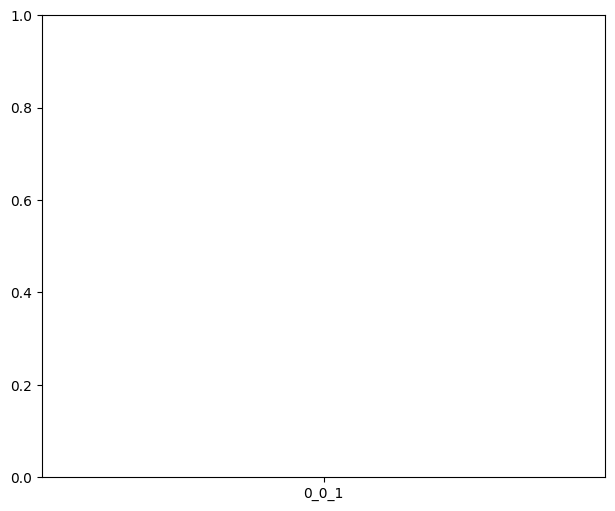

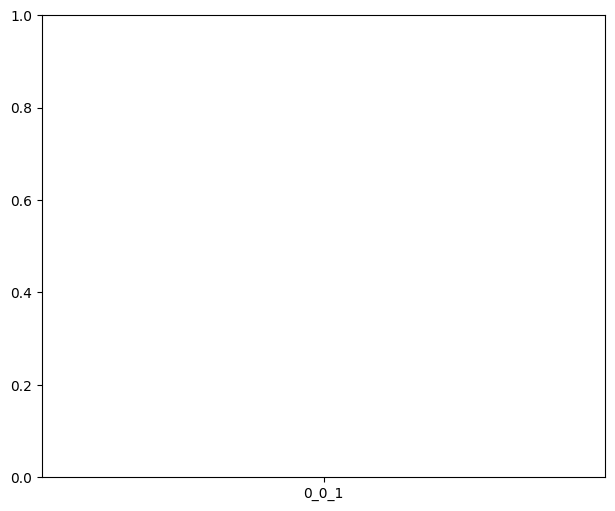

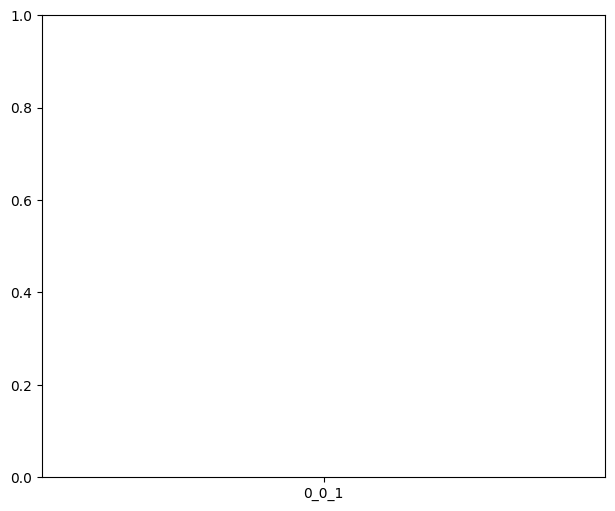

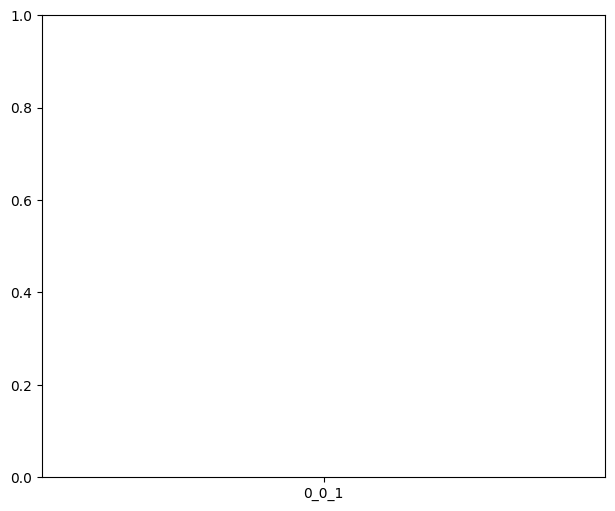

In [ ]:
def main():
    try:
        print("="*50)
        print("开始执行混合HED-CORnet模型实验")
        print("="*50)

        start_time = datetime.now()
        print(f"实验开始时间: {start_time}")

        ensure_directories()

        print("\n[1/3] 开始训练混合模型...")
        try:
            hybrid_model = train_hybrid_model(num_epochs=10)
            print("模型训练完成!")
        except Exception as e:
            print(f"训练过程中发生错误: {e}")
            print("尝试继续执行后续步骤...")

        print("\n[2/3] 准备模型评估...")
        hybrid_model_path = os.path.join(MODEL_DIR, "hybrid", "hybrid_model.pt")

        if not os.path.exists(hybrid_model_path):
            print(f"警告: 未找到保存的模型 {hybrid_model_path}")
            best_model_path = os.path.join(MODEL_DIR, "hybrid", "best_model.pt")
            if os.path.exists(best_model_path):
                hybrid_model_path = best_model_path
                print(f"将使用最佳模型: {best_model_path}")
            else:
                print("警告: 未找到最佳模型，模型比较和显著图生成可能失败")

        print("加载数据集...")
        train_loader, val_loader, train_dataset, val_dataset = get_data_loaders()
        print("\n[3/3] 生成模型比较结果和显著图...")
        try:
            predict_models_comparison(hybrid_model_path)
            print("模型预测比较完成")
        except Exception as e:
            print(f"模型比较过程中发生错误: {e}")

        try:
            generate_hybrid_saliency_maps(
                dataset=val_dataset,
                hybrid_model_path=hybrid_model_path,
                top_percent=0.1,
                intensity=0.9,
                num_images=10
            )
            print("显著图生成完成")
        except Exception as e:
            print(f"显著图生成过程中发生错误: {e}")

        end_time = datetime.now()
        duration = end_time - start_time

        print("\n" + "="*50)
        print(f"实验结束时间: {end_time}")
        print(f"总耗时: {duration}")
        print("混合HED-CORnet模型实验完成!")
        print("="*50)

        experiment_summary = {
            "experiment_name": "混合HED-CORnet模型实验",
            "start_time": str(start_time),
            "end_time": str(end_time),
            "duration_seconds": duration.total_seconds(),
            "status": "完成"
        }

        with open(os.path.join(MODEL_DIR, "experiment_summary.json"), 'w', encoding='utf-8') as f:
            json.dump(experiment_summary, f, indent=2, ensure_ascii=False)

    except Exception as e:
        print(f"实验过程中发生严重错误: {e}")
        print("实验未能完全完成")

from datetime import datetime

main()

In [ ]:
# import shutil
# shutil.rmtree('/content/drive/MyDrive/NE240/Holistic Processing /Fifth Experiment')